<a href="https://colab.research.google.com/github/phamthien300820/CS114.K21/blob/master/ML_CCN_5layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Khai báo thư viện cần dùng

In [2]:
# Khai báo thư viện cần dùng
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2


## Tiền xử lý dữ liệu


In [3]:
#Tạo các nhãn
data_path='/content/drive/My Drive/Machine_Learning Helmet'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'Không có xe máy': 0, 'Có người đi xe máy': 1}
['Không có xe máy', 'Có người đi xe máy']
[0, 1]


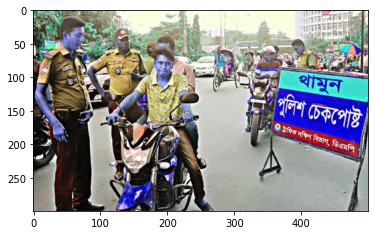

In [4]:
#In thử 1 hình trong file dữ liệu
img = cv2.imread("/content/drive/My Drive/Machine_Learning Helmet/Có người đi xe máy/053142803.jpg")
plt.imshow(img)
plt.show()

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
data=[]
target=[]


for category in categories: #duyệt các file trong file Machine_Learning Helmet
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names: #duyệt các file ảnh ở trong các file dữ liệu  
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Chuyển ảnh sang màu xám và resize 224*224
            resized=cv2.resize(gray,(224,224))  
            image = preprocess_input(resized)
            data.append(image) #thêm ảnh sau khi preprocess vào data
            target.append(label_dict[category])
            #thêm nhãn của ảnh đó vào target
           

        except Exception as e:
            print('Exception:',e)
            #Nếu dữ liệu mình nhập vào bị lỗi hoặc không phải ảnh thì bỏ qua.

In [ ]:
import numpy as np

data=np.array(data)
data=np.reshape(data,(data.shape[0],224,224,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


In [18]:
print(np.shape(data))
np.shape(target)


(2483, 224, 224)


(2483,)

Chia tập dữ liệu train, test


In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.2,random_state=42)

Code sinh thêm dữ liệu sử dụng ở model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=40,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

##Model


Tạo model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer

model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Train model

In [ ]:
print("[INFO] training head...")
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
H = model.fit(
	aug.flow(train_data, train_target, batch_size=64),
	steps_per_epoch=len(train_data) // 64,
	validation_data=(test_data, test_target),
	validation_steps=len(test_data) // 64,
	epochs=30,callbacks=[checkpoint])

[INFO] training head...
Epoch 1/30
26/26 [==============================] - 742s 29s/step - loss: 0.9000 - accuracy: 0.5468 - val_loss: 0.6960 - val_accuracy: 0.4988
Epoch 2/30
26/26 [==============================] - 721s 28s/step - loss: 0.6737 - accuracy: 0.5861 - val_loss: 0.6231 - val_accuracy: 0.6595
Epoch 3/30
26/26 [==============================] - 742s 29s/step - loss: 0.6542 - accuracy: 0.6046 - val_loss: 0.6087 - val_accuracy: 0.6571
Epoch 4/30
26/26 [==============================] - 691s 27s/step - loss: 0.6508 - accuracy: 0.6195 - val_loss: 0.5919 - val_accuracy: 0.6882
Epoch 5/30
26/26 [==============================] - 713s 27s/step - loss: 0.6434 - accuracy: 0.6117 - val_loss: 0.5970 - val_accuracy: 0.6691
Epoch 6/30
26/26 [==============================] - 710s 27s/step - loss: 0.6344 - accuracy: 0.6548 - val_loss: 0.5750 - val_accuracy: 0.7050
Epoch 7/30
26/26 [==============================] - 686s 26s/step - loss: 0.6235 - accuracy: 0.6373 - val_loss: 0.5612 - val

In [ ]:
predIdxs = model.predict(test_data, batch_size=64)

In [ ]:
predIdxs = np.argmax(predIdxs)

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='lower right')
    
    plt.show()


In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 200)     2000      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 200)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 200)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 100)     180100    
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 100)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 291600)           

Cài đặt lưu biểu đồ kết quả

In [ ]:
TRAINING_PLOT_PATH = os.path.sep.join(["training_plot_val.png"])

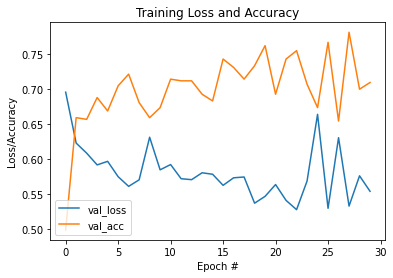

In [ ]:
import matplotlib.pyplot as plt

#plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, 30), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, 30), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)

##Thử model với bộ dữ liệu test và tính điểm F1

In [ ]:
y_predict=model.predict(test_data)
y_predict=np.argmax(y_predict, axis=1)
y_true=np.argmax(test_target, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predict, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.88      0.49      0.63       211
           1       0.64      0.93      0.76       206

    accuracy                           0.71       417
   macro avg       0.76      0.71      0.70       417
weighted avg       0.76      0.71      0.70       417



##Load lại model và thử nghiệm ở ảnh mới

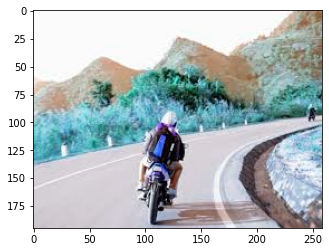

Có xe máy trong hình


In [ ]:
import cv2,os
from tensorflow.keras.models import load_model
model = load_model("/content/drive/My Drive/Đa phương tiện/model-023.model")
img = cv2.imread("/content/images.jfif")
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           

resized=cv2.resize(gray,(224,224))  

reshaped=np.reshape(resized,(1,224,224,1))
image = preprocess_input(reshaped)

a=model.predict(image)
plt.imshow(img)
plt.show()


if a[0][1] > a[0][0]:
  print('Có xe máy trong hình')
else :
  print('Không có xe máy trong hình')